<div style="background-color: #add8e6; padding: 10px; color: black; padding-top: 2rem; padding-left: 1rem">

# Limitation(s) of Sklearn’s Non-Negative Matrix Factorization Library

</div>

## Project Outline

Load the movie ratings data (as in the HW3-recommender-system) and use matrix factorization technique(s) and predict the missing ratings from the test data. Measure the RMSE. You should use sklearn library.

Make sure that your notebook includes the following:

use's sklearn's non-negative matrix factorization

notebook shows the RMSE with an analysis of what that RMSE means

Discuss the results and why they did not work well compared to simple baseline or similarity-based methods we’ve done in Module 3. Can you suggest a way(s) to fix it?

Based on data set from https://www.kaggle.com/datasets/odedgolden/movielens-1m-dataset?select=movies.dat

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import NMF
from sklearn.metrics import mean_squared_error

<div style="background-color: #add8e6; padding: 10px; color: black; padding-top: 2rem; padding-left: 1rem">

# Part 1

</div>

In [2]:
moviesDataSet = pd.read_csv('./sampleData/movies.dat', sep = "::", names = ['MovieID', 'Title', 'Genres'], encoding='latin-1', engine='python')
ratingsDataSet = pd.read_csv('./sampleData/ratings.dat', sep = "::", names = ['UserID', 'MovieID', 'Rating', 'Timestamp'], encoding='latin-1', engine='python')
usersDataSet = pd.read_csv('./sampleData/users.dat', sep = "::", names = ['UserID', 'Gender', 'Age', 'Occupation', 'ZipCode'], encoding='latin-1', engine='python')

## Data Inspection

In [3]:
print("---------------- Movies Table ----------------\n", moviesDataSet)
print("---------------- Ratings Table ----------------\n", ratingsDataSet)
print("---------------- Users Table ----------------\n", usersDataSet)


---------------- Movies Table ----------------
       MovieID                               Title  \
0           1                    Toy Story (1995)   
1           2                      Jumanji (1995)   
2           3             Grumpier Old Men (1995)   
3           4            Waiting to Exhale (1995)   
4           5  Father of the Bride Part II (1995)   
...       ...                                 ...   
3878     3948             Meet the Parents (2000)   
3879     3949          Requiem for a Dream (2000)   
3880     3950                    Tigerland (2000)   
3881     3951             Two Family House (2000)   
3882     3952               Contender, The (2000)   

                            Genres  
0      Animation|Children's|Comedy  
1     Adventure|Children's|Fantasy  
2                   Comedy|Romance  
3                     Comedy|Drama  
4                           Comedy  
...                            ...  
3878                        Comedy  
3879               

## Exploratory Data Analysis

In [4]:
# Creates a dict to map movie IDs to indices
movieIdDict = {movie_id: index for index, movie_id in enumerate(moviesDataSet['MovieID'])}

# I use vectorization for ratings and genres
ratingsVectorization = np.zeros((len(usersDataSet), len(moviesDataSet)))

for _, row in ratingsDataSet.iterrows():
    ratingsVectorization[row['UserID'] - 1, movieIdDict[row['MovieID']]] = row['Rating']

genreList = list(set('|'.join(moviesDataSet['Genres']).split('|')))
movieGenres = np.zeros((len(moviesDataSet), len(genreList)))

for _, row in moviesDataSet.iterrows():
    for genre in row['Genres'].split('|'):
        movieGenres[movieIdDict[row['MovieID']], genreList.index(genre)] = 1

# Lastly I calculate the user averages
userAverageRatings = np.copy(ratingsVectorization)

userMeans = np.nanmean(np.where(userAverageRatings > 0, userAverageRatings, np.nan), axis=1)
userAverageRatings[np.arange(len(usersDataSet)), :] = np.where(userAverageRatings == 0, userMeans[:, None], userAverageRatings)

print(userAverageRatings)

[[5.         4.18867925 4.18867925 ... 4.18867925 4.18867925 4.18867925]
 [3.71317829 3.71317829 3.71317829 ... 3.71317829 3.71317829 3.71317829]
 [3.90196078 3.90196078 3.90196078 ... 3.90196078 3.90196078 3.90196078]
 ...
 [3.8        3.8        3.8        ... 3.8        3.8        3.8       ]
 [3.87804878 3.87804878 3.87804878 ... 3.87804878 3.87804878 3.87804878]
 [3.         3.57771261 3.57771261 ... 3.57771261 3.57771261 3.57771261]]


## Model Construction

In [5]:
trainData = userAverageRatings[100:]
testData = userAverageRatings[:100]

nmfModel = NMF(n_components = 200, 
            beta_loss = 'frobenius',
            random_state = 101, 
            max_iter = 500
        ).fit(trainData)

modelCompoents = nmfModel.components_
modelTransform = nmfModel.transform(testData).T
print(modelTransform.shape)

predictions = np.dot(modelCompoents.T, modelTransform)
print(predictions.T)
print(testData)

(200, 100)
[[4.32408751 4.16601153 4.17705446 ... 4.16799201 4.21104974 4.19823807]
 [3.87219924 3.70039282 3.64382996 ... 3.69490099 3.7590098  3.74664916]
 [3.99321796 3.88606634 3.8974834  ... 3.88394055 3.89980939 3.91358453]
 ...
 [3.91331786 3.78344693 3.75268084 ... 3.78359737 3.81289378 3.81150277]
 [3.46873053 3.15910745 3.18019049 ... 3.22004162 3.2449895  3.22216014]
 [3.11216289 2.98539972 2.98932255 ... 3.02632003 3.01558114 3.02912834]]
[[5.         4.18867925 4.18867925 ... 4.18867925 4.18867925 4.18867925]
 [3.71317829 3.71317829 3.71317829 ... 3.71317829 3.71317829 3.71317829]
 [3.90196078 3.90196078 3.90196078 ... 3.90196078 3.90196078 3.90196078]
 ...
 [3.8        3.8        3.8        ... 3.8        3.8        3.8       ]
 [3.         3.21495327 3.21495327 ... 3.21495327 3.21495327 3.21495327]
 [3.02631579 3.02631579 3.02631579 ... 3.02631579 3.02631579 3.02631579]]


## RSME Calculations

## RSME Method 1
- This RMSE is calculated based on predictions generated by the model for a subset of the dataset.
- This reflects the model's performance in predicting user ratings for movies in the subset.

In [6]:
# Standard RSME calculations
hundredUsersToPredict = ratingsDataSet[ratingsDataSet['UserID'] < 100]
trueValues = hundredUsersToPredict['Rating'].to_list()

userIndices = hundredUsersToPredict['UserID'].values - 1
movieIndices = hundredUsersToPredict['MovieID'].apply(lambda x: movieIdDict.get(x, -1)).values

predictedVals = predictions.T[userIndices, movieIndices].tolist()

rmse = mean_squared_error(trueValues, predictedVals)
print('Standard RMSE:', rmse)


Standard RMSE: 0.9010878317744597


## RSME Method 2
- This RMSE is determined based on a simpler method where every prediction is set to the constant value 4.
- It serves as a baseline comparison, indicating the performance when predictions are consistently set to a single value.

In [7]:
# The below predicts every value to be 4
predictedFourList = [4] * 12900

predictedFourRsme = mean_squared_error(trueValues, predictedFourList)
print('All Predicted as 4 RMSE: ' + str(predictedFourRsme))

All Predicted as 4 RMSE: 1.3910077519379844


## RSME Method 3
- This RMSE is determined after replacing certain values in the test data with user mean ratings.
- It assesses the model's performance when missing values are filled with user mean ratings, aiming to address sparsity.

In [8]:
testDataCopy = np.copy(testData)

# User indices are extracted of hundredUsersToPredict and adjusted to 0-based indices.
userIndices = hundredUsersToPredict['UserID'].values - 1

# Movie indices applies the lamba function to every movie id.
movieIndices = hundredUsersToPredict['MovieID'].apply(lambda x: movieIdDict.get(x, -1)).values
testDataCopy[userIndices, movieIndices] = testData[userIndices].mean(axis=1)

modelTransform = nmfModel.transform(testDataCopy).T
emptiedPredictions = np.dot(modelCompoents.T, modelTransform)

predictedVals = emptiedPredictions.T[userIndices, movieIndices].tolist()
rsmeEmptied = mean_squared_error(trueValues, predictedVals)
print('Emptied Out RMSE:', rsmeEmptied)

Emptied Out RMSE: 1.0257197290708486


## RSME Method 4
- This RMSE is calculated based on predictions where missing values are replaced by the mean rating for each user.
- It evaluates the model's performance when predictions are guided by user mean ratings for users in the subset.

In [9]:
# The below focuses on using the calculated user mean for any sort of missing values
predictedList = []

for index, row in hundredUsersToPredict.iterrows():
    predictedList += [ratingsDataSet[ratingsDataSet['UserID'] == row['UserID']].groupby('UserID').mean()['Rating']]

rmse_user_average = mean_squared_error(trueValues, predictedList)
print('User Mean RMSE: ' + str(rmse_user_average))

User Mean RMSE: 1.0447352392533193


## Comparison Chart

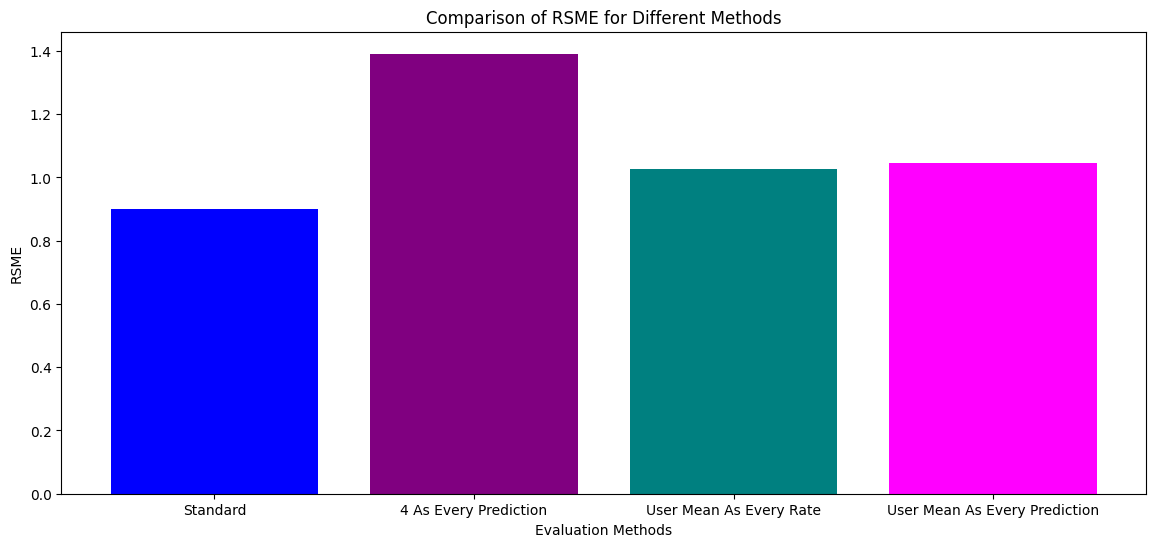

In [10]:
rmseValues = [rmse, predictedFourRsme, rsmeEmptied, rmse_user_average]

# Plotting the RSME values for different methods and increasing the size.
fig, subPlots = plt.subplots(figsize=(14, 6))

plt.bar(['Standard', '4 As Every Prediction', 'User Mean As Every Rate', 'User Mean As Every Prediction'], 
        rmseValues, color = ['blue', 'purple', 'teal', 'magenta'])

# Adding a title and labels
plt.title("Comparison of RSME for Different Methods")
plt.xlabel("Evaluation Methods")
plt.ylabel("RSME")
plt.show()

<div style="background-color: #add8e6; padding: 10px; color: black; padding-top: 2rem; padding-left: 1rem">

# Part 2

</div>

When looking at the final results above, you can tell from the RSME that the Non-negative Matrix Factorization really didn't perform well with this dataset. Especially when it came to making predictions on data that it has not seen. It really didn't add much compared to the standard basic prediction of user ratings.

Since the dataset has a sense of sparsity when it comes to the information within, this may add limitations when using NMF. Since many of the user-movie interactions are missing data, it hinders the RSME methods from getting the best results in most cases.

There are possibilities that we can do to address these concerns though. One strategy to solve the issues I mentioned above could be grouping the users/movies into smaller sets of data. If models are built using more localized subsets of data, it would be easier to eliminate the issues that we face in this dataset with the sparse data. This in turn, could enhance the accuracy of our predictions.  A one size fits all model doesn't really work here and being able to refine the model on smaller, targeted subsets would improve accuracy.